### Gender Recognition by Voice and Speech Analysis
Neste projeto utilizei de técnicas de análise de dados, seleção de variáveis e modelos de machine learning, afim de criar um modelo capaz de detectar o gênero(sexo) à partir de dados de frequências emitidas durante a fala.

#### Resumo sobre o dataset
This database was created to identify a voice as male or female, based upon acoustic properties of the voice and speech. The dataset consists of 3,168 recorded voice samples, collected from male and female speakers. The voice samples are pre-processed by acoustic analysis in R using the seewave and tuneR packages, with an analyzed frequency range of 0hz-280hz (human vocal range).

#### Dicionário de variáveis
→ meanfreq: mean frequency (in kHz)
→ sd: standard deviation of frequency

→ median: median frequency (in kHz)

→ Q25: first quantile (in kHz)

→ Q75: third quantile (in kHz)

→ IQR: interquantile range (in kHz)

→ skew: skewness (see note in specprop description)

→ kurt: kurtosis (see note in specprop description)

→ sp.ent: spectral entropy

→ sfm: spectral flatness

→ mode: mode frequency

→ centroid: frequency centroid (see specprop)

→ peakf: peak frequency (frequency with highest energy)

→ meanfun: average of fundamental frequency measured across acoustic signal

→ minfun: minimum fundamental frequency measured across acoustic signal

→ maxfun: maximum fundamental frequency measured across acoustic signal

→ meandom: average of dominant frequency measured across acoustic signal

→ mindom: minimum of dominant frequency measured across acoustic signal

→ maxdom: maximum of dominant frequency measured across acoustic signal

→ dfrange: range of dominant frequency measured across acoustic signal

→ modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range

→ label: male or female

In [1]:
# importando as bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # Utiliza-se regressão logística para esta tarefa
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Carregando o arquivo csv
voice = pd.read_csv('voice.csv')

In [3]:
# Visualizando os dados
voice.head(10)

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
5,0.132786,0.079557,0.119090,0.067958,0.209592,0.141634,1.932562,8.308895,0.963181,0.738307,...,0.132786,0.110132,0.017112,0.253968,0.298222,0.007812,2.726562,2.718750,0.125160,male
6,0.150762,0.074463,0.160106,0.092899,0.205718,0.112819,1.530643,5.987498,0.967573,0.762638,...,0.150762,0.105945,0.026230,0.266667,0.479620,0.007812,5.312500,5.304688,0.123992,male
7,0.160514,0.076767,0.144337,0.110532,0.231962,0.121430,1.397156,4.766611,0.959255,0.719858,...,0.160514,0.093052,0.017758,0.144144,0.301339,0.007812,0.539062,0.531250,0.283937,male
8,0.142239,0.078018,0.138587,0.088206,0.208587,0.120381,1.099746,4.070284,0.970723,0.770992,...,0.142239,0.096729,0.017957,0.250000,0.336476,0.007812,2.164062,2.156250,0.148272,male
9,0.134329,0.080350,0.121451,0.075580,0.201957,0.126377,1.190368,4.787310,0.975246,0.804505,...,0.134329,0.105881,0.019300,0.262295,0.340365,0.015625,4.695312,4.679688,0.089920,male


In [4]:
# Verificando o formato dos dados
voice.shape

(3168, 21)

In [5]:
# informações sobre o dataset (verificamos que não há valores missing)
voice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

In [6]:
# Resumo estatístico
voice.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,0.165282,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,0.077203,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,0.000000,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,0.118016,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,0.186599,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,0.221104,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374


In [7]:
# Visualizando a maior e menor frequência média do dataset
maiorfreq = voice.meanfreq.max()
menorfreq = voice.meanfreq.min()
print(maiorfreq)
print(menorfreq)

0.251123758720282
0.0393633425835608


In [8]:
# visualizando os gêneros das frequência extremas
voice.query('meanfreq == 0.251123758720282 | meanfreq == 0.0393633425835608').head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
454,0.039363,0.060447,0.013588,0.005581,0.042946,0.037366,4.593055,27.934091,0.817450,0.282282,...,0.039363,0.101011,0.016048,0.246154,0.256104,0.007812,3.242188,3.234375,0.139629,male
2359,0.251124,0.034210,0.261224,0.247347,0.273469,0.026122,3.102230,13.091336,0.780359,0.122430,...,0.251124,0.185008,0.047809,0.279070,1.891544,0.046875,9.890625,9.843750,0.081256,female


In [9]:
# Verificando o balanceamento de classes
voice.groupby('label').size()

label
female    1584
male      1584
dtype: int64

<AxesSubplot:>

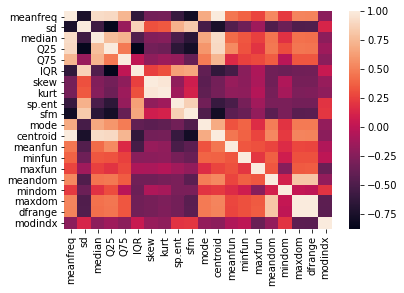

In [10]:
# Utilizando o Seaborn para plotar o gráfico de correlação entre as variáveis
matrix = voice.corr()
sns.heatmap(matrix)

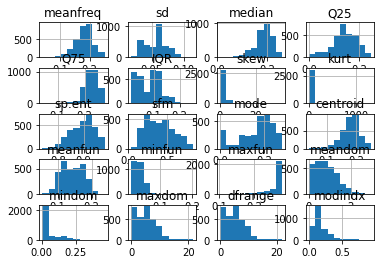

In [11]:
# Histograma Univariado para verificar as distribuições de frequência 
voice.hist()
plt.show()

In [12]:
voice.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [13]:
# Normalizando os dados
# Normalizando os dados (comprimento igual a 1)


# Separando o array em componentes de input e output
x = voice.values[:,0:20]
y = voice.values[:,20]

# Gerando os dados normalizados
scaler = Normalizer().fit(x)
x = scaler.transform(x)
print(x)

[[2.17617784e-04 2.33854332e-04 1.16586000e-04 ... 2.84394601e-05
  0.00000000e+00 0.00000000e+00]
 [1.03949004e-04 1.05998242e-04 6.33512605e-05 ... 8.61205821e-05
  7.38176418e-05 8.28829663e-05]
 [7.54010970e-05 8.17537244e-05 3.58092745e-05 ... 1.52381101e-05
  7.61905503e-06 4.53599556e-05]
 ...
 [1.74525550e-02 1.17694733e-02 2.25726034e-02 ... 3.60891396e-01
  3.59931578e-01 2.39273908e-02]
 [1.85888533e-02 1.17269258e-02 2.39351586e-02 ... 4.65016533e-01
  4.64005627e-01 4.02424083e-02]
 [2.66413838e-02 1.49511312e-02 2.94639263e-02 ... 8.92860655e-02
  8.80285153e-02 5.63382498e-02]]


In [14]:
voice_norm = pd.DataFrame({'meanfreq': x[:, 0], 'sd': x[:, 1], 'median': x[:, 2], 'Q25': x[:, 3], 'Q75': x[:, 4], 
                          'IQR': x[:, 5], 'skew': x[:, 6], 'kurt': x[:, 7], 'sp.ent': x[:, 8], 'sfm': x[:, 9], 
                          'mode': x[:, 10], 'centroid': x[:, 11], 'meanfun':  x[:, 12], 'minfun': x[:, 13], 'maxfun':
                          x[:, 14], 'meandom': x[:, 15], 'mindom': x[:, 16], 'maxdom': x[:, 17], 'dfrange': x[:, 18]
                          ,'modindx': x[:, 19]})

voice_norm.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,0.000218,0.000234,0.000117,0.000055,0.000328,0.000273,0.046826,0.998895,0.003252,0.001791,0.000000,0.000218,0.000307,0.000057,0.001004,0.000028,0.000028,0.000028,0.000000,0.000000
1,0.000104,0.000106,0.000063,0.000031,0.000146,0.000115,0.035312,0.999375,0.001405,0.000809,0.000000,0.000104,0.000170,0.000025,0.000394,0.000014,0.000012,0.000086,0.000074,0.000083
2,0.000075,0.000082,0.000036,0.000008,0.000129,0.000120,0.029996,0.999550,0.000825,0.000467,0.000000,0.000075,0.000096,0.000015,0.000264,0.000008,0.000008,0.000015,0.000008,0.000045
3,0.032713,0.015599,0.034180,0.020892,0.044984,0.024092,0.266680,0.903614,0.208382,0.157311,0.018144,0.032713,0.019244,0.003850,0.054079,0.043587,0.001690,0.121677,0.119987,0.053456
4,0.014886,0.008719,0.013733,0.008673,0.022700,0.014027,0.121315,0.477439,0.107079,0.086325,0.011486,0.014886,0.011722,0.001865,0.029378,0.078530,0.000861,0.604206,0.603346,0.022945


In [15]:
voice_norm['label'] = voice['label']

In [16]:
voice.tail(10)

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
3158,0.183667,0.040607,0.182534,0.156480,0.207646,0.051166,2.054138,7.483019,0.898138,0.313925,...,0.183667,0.149237,0.018648,0.262295,0.550312,0.007812,3.421875,3.414062,0.166503,female
3159,0.168794,0.085842,0.188980,0.095558,0.240229,0.144671,1.462248,5.077956,0.956201,0.706861,...,0.168794,0.182863,0.020699,0.271186,0.988281,0.007812,5.882812,5.875000,0.268617,female
3160,0.151771,0.089147,0.185970,0.058159,0.230199,0.172040,1.227710,4.304354,0.962045,0.744590,...,0.151771,0.201600,0.023426,0.266667,0.766741,0.007812,4.007812,4.000000,0.192220,female
3161,0.170656,0.081237,0.184277,0.113012,0.239096,0.126084,1.378256,5.431663,0.950750,0.658558,...,0.170656,0.198475,0.160000,0.253968,0.414062,0.007812,0.734375,0.726562,0.336918,female
3162,0.146023,0.092525,0.183434,0.041747,0.224337,0.182590,1.384981,5.118927,0.948999,0.659825,...,0.146023,0.195640,0.039506,0.275862,0.533854,0.007812,2.992188,2.984375,0.258924,female
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female
3167,0.165509,0.092884,0.183044,0.070072,0.250827,0.180756,1.705029,5.769115,0.938829,0.601529,...,0.165509,0.185607,0.062257,0.271186,0.227022,0.007812,0.554688,0.546875,0.350000,female


In [17]:
voice_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

In [18]:
# Utilizando o OneHotEncoders para transformar os labels em 0 e 1
# import category_encoders as ce
from category_encoders.one_hot import OneHotEncoder
one_hot_enc = OneHotEncoder(cols = ['label'])
voice_norm['label'] = one_hot_enc.fit_transform(voice_norm['label'])
voice_norm.groupby('label').size()
# 1 = male ; 0 = female

label
0    1584
1    1584
dtype: int64

In [19]:
# Definindo os principais atributos do dataset que explicam os labels
x_train, x_test, y_train, y_test = train_test_split(voice_norm.drop(['label'], axis = 1), voice_norm['label'],
                                                  test_size = 0.3,  random_state = 0)
x_train.shape, x_test.shape


((2217, 20), (951, 20))

In [20]:
# Utilizando mutual information
mi = mutual_info_regression(x_train.fillna(0), y_train)
mi = pd.Series(mi)
mi.index = x_train.columns
mi.sort_values(ascending = False)

IQR         0.278979
sd          0.186449
sfm         0.170965
sp.ent      0.088127
maxfun      0.078844
Q75         0.067495
mindom      0.055837
median      0.052898
modindx     0.051928
mode        0.045735
centroid    0.044124
meanfreq    0.044124
meanfun     0.037370
minfun      0.033652
skew        0.031044
maxdom      0.020603
meandom     0.019382
Q25         0.019188
dfrange     0.009739
kurt        0.003652
dtype: float64

<AxesSubplot:>

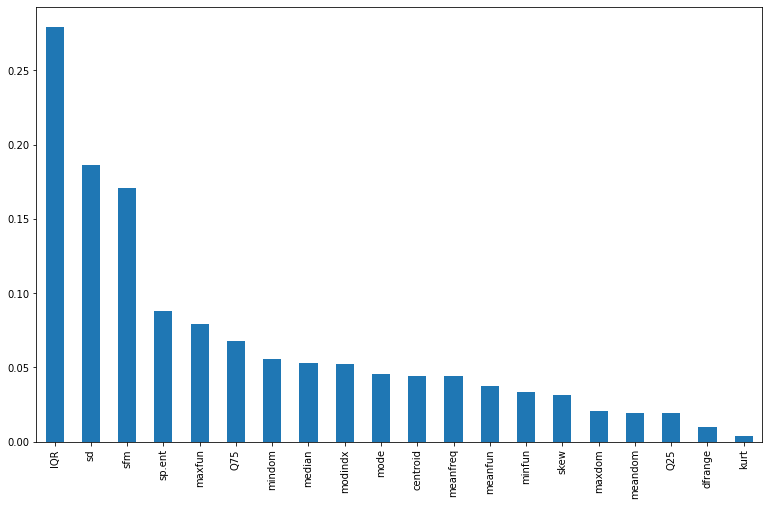

In [21]:
# plotando o gráfico afim de visualizar as melhores colunas
mi.sort_values(ascending = False).plot.bar(figsize = (13,8))

<AxesSubplot:xlabel='IQR', ylabel='meanfun'>

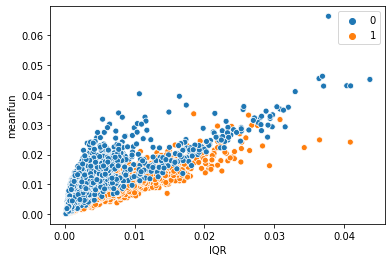

In [22]:
#### Plotando algumas relações de frequência em relação ao sexo
sns.scatterplot(data = voice_norm, x = voice_norm['IQR'], y = voice_norm['meanfun'], hue=voice_norm['label'].tolist())

In [23]:
# Eliminação Recursiva de Variáveis

# Separando o array em componentes de input e output
X = voice_norm.values[:,0:20]
y = voice_norm.values[:,20]

# Criação do modelo
modelo = LogisticRegression()

# RFE
rfe = RFE(modelo, 7)
fit = rfe.fit(x, y)

# Print dos resultados
print("Variáveis Preditoras:", voice_norm.columns[0:20])
print("Variáveis Selecionadas: %s" % fit.support_)
print("Ranking dos Atributos: %s" % fit.ranking_)
print("Número de Melhores Atributos: %d" % fit.n_features_)

Variáveis Preditoras: Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx'],
      dtype='object')
Variáveis Selecionadas: [False False False  True  True  True  True False  True  True False False
  True False False False False False False False]
Ranking dos Atributos: [11  2  9  1  1  1  1  6  1  1  8 10  1 14  4 13  3  5 12  7]
Número de Melhores Atributos: 7


In [24]:
voice_mutual_info = voice_norm[['IQR','sd','sfm','sp.ent','maxfun','Q75','mindom', 'label']]
voice_mutual_info.head()

,IQR,sd,sfm,sp.ent,maxfun,Q75,mindom,label
0,0.000273,0.000234,0.001791,0.003252,0.001004,0.000328,0.000028,1
1,0.000115,0.000106,0.000809,0.001405,0.000394,0.000146,0.000012,1
2,0.000120,0.000082,0.000467,0.000825,0.000264,0.000129,0.000008,1
3,0.024092,0.015599,0.157311,0.208382,0.054079,0.044984,0.001690,1
4,0.014027,0.008719,0.086325,0.107079,0.029378,0.022700,0.000861,1


In [25]:
voice_recursivo = voice_norm[['Q25', 'Q75', 'IQR', 'skew','sp.ent', 'sfm','meanfun','label']]
voice_recursivo.head()

,Q25,Q75,IQR,skew,sp.ent,sfm,meanfun,label
0,0.000055,0.000328,0.000273,0.046826,0.003252,0.001791,0.000307,1
1,0.000031,0.000146,0.000115,0.035312,0.001405,0.000809,0.000170,1
2,0.000008,0.000129,0.000120,0.029996,0.000825,0.000467,0.000096,1
3,0.020892,0.044984,0.024092,0.266680,0.208382,0.157311,0.019244,1
4,0.008673,0.022700,0.014027,0.121315,0.107079,0.086325,0.011722,1


In [26]:
# Utilizando Regressão linear à partir dos dados definidos como melhores pelo mutual information

# Selecionando as features conforme o mutual information
array = voice_mutual_info.values

# Separando o array em componentes de input e output
X = array[:,0:7]
Y = array[:,7]

# Definindo o tamanho das amostras
teste_size = 0.33

# Isso é importante para comparar a acurácia com outros algoritmos de Machine Learning.
seed = 7

# Criando os conjuntos de dados de treino e de teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size = teste_size, random_state = seed)

# Criação do modelo
modelo = LogisticRegression()

# Treinamento do modelo
modelo.fit(X_treino, Y_treino)

# Score do modelo nos dados de teste
result = modelo.score(X_teste, Y_teste)
print("Acurácia nos Dados de Teste: %.3f%%" % (result * 100.0))

Acurácia nos Dados de Teste: 69.694%


In [27]:
# Selecionando as features conforme o método de eliminação recursiva de variáveis
array = voice_recursivo.values

# Separando o array em componentes de input e output
X = array[:,0:7]
Y = array[:,7]

# Definindo o tamanho das amostras
teste_size = 0.33

# Isso é importante para comparar a acurácia com outros algoritmos de Machine Learning.
seed = 7

# Criando os conjuntos de dados de treino e de teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size = teste_size, random_state = seed)

# Criação do modelo
modelo2 = LogisticRegression()

# Treinamento do modelo
modelo2.fit(X_treino, Y_treino)

# Score do modelo nos dados de teste
result = modelo2.score(X_teste, Y_teste)
print("Acurácia nos Dados de Teste: %.3f%%" % (result * 100.0))

Acurácia nos Dados de Teste: 69.790%


O método de eliminação recursiva de variáveis possibilitou uma melhor acurácia ao se aplicar o modelo de regressão logística.

In [28]:
# Carregando os dados
array = voice_recursivo.values

# Separando o array em componentes de input e output
X = array[:,0:7]
Y = array[:,7]

# Definindo o tamanho dos dados de treino e de teste
teste_size = 0.33
seed = 7

# Criando o dataset de treino e de teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, Y, test_size = teste_size, random_state = seed)

# Criando o modelo
modeloxg = XGBClassifier()

# Treinando o modelo
modeloxg.fit(X_treino, y_treino)

# Print do modelo
print(modeloxg)

# Fazendo previsões
y_pred = modeloxg.predict(X_teste)
previsoes = [round(value) for value in y_pred]

# Avaliando as previsões
accuracy = accuracy_score(y_teste, previsoes)
print("\nAcurácia: %.2f%%" % (accuracy * 100.0))

[14:14:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Acurácia: 95.70%


Por fim foi possível alcançar um acurácia de 95.70% ao se utilizar o algoritmo XGBooster.

Fim.